#Localización del sonido por animales binaurales.

T. N. Parks y E. W. Rubel sugirieron un mecanismo de cómo los pollos pueden localizar sonidos empleando una red neuronal simple. La red neuronal se muestra en la siguiente figura:

![](https://raw.githubusercontent.com/Oscarhg42/Neural-Systems/Oscar/images/photo.JPG)

Esta red describe caracterísitcas escenciales del núcleo auditivo de los pollos. En este modelo cada oído tiene varios axones que salen de él, y cada uno de estos axones llega a una direfente neurona central localizada en el tálamo. Cuando una de las neuronas centrales reciben simultaneamente estimulación de ambos lados, derecho e ixquierdo, ésta dispara un potencial de acción. Si solo un lado la excita, no hay disparo. La señal producida por una de estas neuronas centrales cuasa una respuesta muscular, y el pollo responde ubicando de donde proviene el sonido girando su cabeza.



##Una red binaural

Una onda acústica entrando en un oído causa que la membrana basilar vibre en una región que corresponde a la frecuencia de la onda acústica. Como respuesta pequeñas céluas de cabello en esa región exitan un axón de una neurona causando que ésta dispare un potencial de acción. 
Este proceso se modela con un VCON. La señal causada por un estímulo en el oído derecho llega a una neurona central que reacciona contrayendo algunos músculos haciendo rotar al pollo la cabeza hacia la derecha, lo mismo sucede cuando entra un estímulo de lado derecho. el sistema de ecuaciones es el siguiente (véase la refernecia [Frank C. Hoppensteadt]):

$$\dot{x}_0=\omega _0+V(x_0) +L(t) $$

$$\ddot{x}_j+\dot{x}_j=\omega_j+V(x_j)+V(x_{j-1})$$

$$\ddot{y}_j+\dot{y}_j=\mu _j +V(y_j)+V(x_j)+V(z_j)$$

$$\dot{z}_j=\omega _j + V(z_j)+V(z_{j-1})$$

$$\dot{z_0}=\omega _0 +V(z_0)+R(t)$$

para $j=1,..,N$ . Un pulso entrando por el lado derecho seguido de un entrando por el oído izquierdo produce pulsos moviéndose a lo largo de las respectivas cadenas de axones.

Se necesita hacer un cambio de variables para pasar aun sistema de ecuaciones de primer orden:

$$\dot{x_j}=u_j \  ; \ \dot{y}=v_j $$

Con esto el sistema se transforma en:

$$\dot{x}_0=\omega _0+V(x_0) +L(t) $$

$$\dot{x_j}=u_j$$

$$\dot{u}_j=\omega_j+V(x_j)+V(x_{j-1})-\dot{x}_j$$

$$\dot{y}=v_j$$

$$\dot{v}_j=\mu _j +V(y_j)+V(x_j)+V(z_j)-\dot{y}_j$$

$$\dot{z}_j=\omega _j + V(z_j)+V(z_{j-1})$$

$$\dot{z_0}=\omega _0 +V(z_0)+R(t)$$

Sin embargo como ya se hizo notar en la parte de [modelos simples de neuronas](https://github.com/Oscarhg42/Neural-Systems/blob/Oscar/Modelos%20b%C3%A1sicos%20de%20redes..ipynb), no se lograron obtener resultados adecuados para ecuaciones difernciales de segundo orden.

Debido a la cantidad ecuaciones diferenciales que deben resolverse para la red de la figura anterior, solo trabajaremos con 9 neuronas.

Debido a que el tálamo es el encargado de procesar los estímulos sensoriales en el cerebro una buena idea para modelar esta red neuronal es partir de las ecuaciones  del modelo de atoll o modelo de [circuito talamocortical](PONER LINK!!!!!) pero haciendo unas pequeñas modificaciones.

$$\dot{r_{i}}=5(1+cos (r_{i})-\cos_{+}(y_{i})+\sigma_{R_i}(t)+10M_R(t))$$

$$\dot{y_{i}}=0.04( \ 1+cos (y_{i})+\tanh(2\cos_{+}(r_{i})) \ )$$

$$\dot{l_{i}}=10(0.1+cos (l_{i})-\cos_{+}(y_{i})+\sigma_{L_i}(t)+10M_L(t))$$

donde $r_i$ son las fases de los potenciales de axión producidos en las neouronas que conducen los estímulos del oído **derecho** a las neuronas centrales localizadas en el tálamo, cuyas fases están dadas por $y_i$; y $l_i$ son las fases de los potenciales de las neuronas conductoras del lado **izquierdo**. 
$\sigma_{R_i}$ y $\sigma_{L_i}$ son los estímulos externos que entran por los oídos derecho e izquierdo, respectivamente, y $M(t)$ es una función que acopla a las neuronas conductoras del lado derecho y $M_L(t)$ acopla a las del lado derecho.

In [1]:
using PyPlot
using TaylorSeries
println(VERSION)

using Compat;

INFO: Loading help data...


0.3.11


In [2]:
function step{T<:Number}(x::Taylor1{T},eps::T)
    orden=length(x.coeffs)
    hs=Number[]
    for i in 1:orden #esto lo hacemos para evitar problemas con los coeficientes de Taylor que 
        #son cero
        if x.coeffs[i]!=0
            push!(hs,x.coeffs[i])
        end 
    end 
    orden=length(hs)
    p1=1/orden
    p2=1/(orden-1)
    den1=hs[orden]
    den2=hs[orden-1]
    h1=(abs(eps/den1))^p1
    h2=(abs(eps/den2))^p2
    h=min(h1,h2)
    #println(hs)

    return h
end 
    

step (generic function with 1 method)

In [3]:
function d{T<:Real}(x::Taylor1{T}) # La función pide un Taylor
    res=(x+((x^2)^0.5))/2.0
    return res
#end    
#function positive{T<:Number}(x::Taylor1{T})
#    obj=(x+(x^2)^0.5)/2
 #   return obj
end 

d (generic function with 1 method)

In [4]:
function tanh(x::Taylor1)
     ap1 = exp(2.0*(x))
    res1 = (ap1-1.0)/(ap1+1.0)
    return res1
end 

tanh (generic function with 1 method)

In [17]:
function xjetN{T<:Number}(arr::Array{T,1},orden::Int,g::Function,σ::Number)
    x1jet=zeros(orden)                             
    y1jet=zeros(orden)
    z1jet=zeros(orden)
    x2jet=zeros(orden)
    y2jet=zeros(orden)
    z2jet=zeros(orden)
    x3jet=zeros(orden)
    y3jet=zeros(orden)
    z3jet=zeros(orden)
    x4jet=zeros(orden)
    y4jet=zeros(orden)
    z4jet=zeros(orden)
    x5jet=zeros(orden)
    y5jet=zeros(orden)
    z5jet=zeros(orden)
    x6jet=zeros(orden)
    y6jet=zeros(orden)
    z6jet=zeros(orden)
    x7jet=zeros(orden)
    y7jet=zeros(orden)
    z7jet=zeros(orden)
    x8jet=zeros(orden)
    y8jet=zeros(orden)
    z8jet=zeros(orden)
    x9jet=zeros(orden)
    y9jet=zeros(orden)
    z9jet=zeros(orden)
  
    x1jet[1]=arr[1] #cond. iniciales
    y1jet[1]=arr[2]
    z1jet[1]=arr[3]
    x2jet[1]=arr[4]
    y2jet[1]=arr[5]
    z2jet[1]=arr[6]
    x3jet[1]=arr[7]
    y3jet[1]=arr[8]
    z3jet[1]=arr[9]
    x4jet[1]=arr[10]
    y4jet[1]=arr[11]
    z4jet[1]=arr[12]
    x5jet[1]=arr[13]
    y5jet[1]=arr[14]
    z5jet[1]=arr[15]
    x6jet[1]=arr[16]
    y6jet[1]=arr[17]
    z6jet[1]=arr[18]
    x7jet[1]=arr[19]
    y7jet[1]=arr[20]
    z7jet[1]=arr[21]
    x8jet[1]=arr[22]
    y8jet[1]=arr[23]
    z8jet[1]=arr[24]
    x9jet[1]=arr[25]
    y9jet[1]=arr[26]
    z9jet[1]=arr[27]
    
    fx1=zeros(orden)
    fy1=zeros(orden)
    fz1=zeros(orden)
    fx2=zeros(orden)
    fy2=zeros(orden)
    fz2=zeros(orden)
    fx3=zeros(orden)
    fy3=zeros(orden)
    fz3=zeros(orden)
    fx4=zeros(orden)
    fy4=zeros(orden)
    fz4=zeros(orden)
    fx5=zeros(orden)
    fy5=zeros(orden)
    fz5=zeros(orden)
    fx6=zeros(orden)
    fy6=zeros(orden)
    fz6=zeros(orden)
    fx7=zeros(orden)
    fy7=zeros(orden)
    fz7=zeros(orden)
    fx8=zeros(orden)
    fy8=zeros(orden)
    fz8=zeros(orden)
    fx9=zeros(orden)
    fy9=zeros(orden)
    fz9=zeros(orden)
    
   
    for k in 1:orden-1
        ax1=Taylor1(x1jet)
        ay1=Taylor1(y1jet)
        az1=Taylor1(z1jet)
        ax2=Taylor1(x2jet)
        ay2=Taylor1(y2jet)
        az2=Taylor1(z2jet)
        ax3=Taylor1(x3jet)
        ay3=Taylor1(y3jet)
        az3=Taylor1(z3jet)
        ax4=Taylor1(x4jet)
        ay4=Taylor1(y4jet)
        az4=Taylor1(z4jet)
        ax5=Taylor1(x5jet)
        ay5=Taylor1(y5jet)
        az5=Taylor1(z5jet)
        ax6=Taylor1(x6jet)
        ay6=Taylor1(y6jet)
        az6=Taylor1(z6jet)
        ax7=Taylor1(x7jet)
        ay7=Taylor1(y7jet)
        az7=Taylor1(z7jet)
        ax8=Taylor1(x8jet)
        ay8=Taylor1(y8jet)
        az8=Taylor1(z8jet)
        ax9=Taylor1(x9jet)
        ay9=Taylor1(y9jet)
        az9=Taylor1(z9jet)
       
        bx1,by1,bz1,bx2,by2,bz2,bx3,by3,bz3,bx4,by4,bz4,bx5,by5,bz5,bx6,by6,bz6,bx7,by7,bz7,bx8,by8,bz8,bx9,by9,bz9=g(ax1,ay1,az1,ax2,ay2,az2,ax3,ay3,az3,ax4,ay4,az4,ax5,ay5,az5,ax6,ay6,az6,ax7,ay7,az7,ax8,ay8,az8,ax9,ay9,az9,σ)
        
        fx1[k]=bx1.coeffs[k]
        fy1[k]=by1.coeffs[k]
        fz1[k]=bz1.coeffs[k]
        fx2[k]=bx2.coeffs[k]
        fy2[k]=by2.coeffs[k]
        fz2[k]=bz2.coeffs[k]
        fx3[k]=bx3.coeffs[k]
        fy3[k]=by3.coeffs[k]
        fz3[k]=bz3.coeffs[k]
        fx4[k]=bx4.coeffs[k]
        fy4[k]=by4.coeffs[k]
        fz4[k]=bz4.coeffs[k]
        fx5[k]=bx5.coeffs[k]
        fy5[k]=by5.coeffs[k]
        fz5[k]=bz5.coeffs[k]
        fx6[k]=bx6.coeffs[k]
        fy6[k]=by6.coeffs[k]
        fz6[k]=bz6.coeffs[k]
        fx7[k]=bx7.coeffs[k]
        fy7[k]=by7.coeffs[k]
        fz7[k]=bz7.coeffs[k]
        fx8[k]=bx8.coeffs[k]
        fy8[k]=by8.coeffs[k]
        fz8[k]=bz8.coeffs[k]
        fx9[k]=bx9.coeffs[k]
        fy9[k]=by9.coeffs[k]
        fz9[k]=bz9.coeffs[k]
        
        
        x1jet[k+1]=fx1[k]/k
        y1jet[k+1]=fy1[k]/k
        z1jet[k+1]=fz1[k]/k
        x2jet[k+1]=fx2[k]/k
        y2jet[k+1]=fy2[k]/k
        z2jet[k+1]=fz2[k]/k
        x3jet[k+1]=fx3[k]/k
        y3jet[k+1]=fy3[k]/k
        z3jet[k+1]=fz3[k]/k
        x4jet[k+1]=fx4[k]/k
        y4jet[k+1]=fy4[k]/k
        z4jet[k+1]=fz4[k]/k
        x5jet[k+1]=fx5[k]/k
        y5jet[k+1]=fy5[k]/k
        z5jet[k+1]=fz5[k]/k
        x6jet[k+1]=fx6[k]/k
        y6jet[k+1]=fy6[k]/k
        z6jet[k+1]=fz6[k]/k
        x7jet[k+1]=fx7[k]/k
        y7jet[k+1]=fy7[k]/k
        z7jet[k+1]=fz7[k]/k
        x8jet[k+1]=fx8[k]/k
        y8jet[k+1]=fy8[k]/k
        z8jet[k+1]=fz8[k]/k
        x9jet[k+1]=fx9[k]/k
        y9jet[k+1]=fy9[k]/k
        z9jet[k+1]=fz9[k]/k
        
    end 
    x1aprox=Taylor1(x1jet,orden)
    y1aprox=Taylor1(y1jet,orden)
    z1aprox=Taylor1(z1jet,orden)
    x2aprox=Taylor1(x2jet,orden)
    y2aprox=Taylor1(y2jet,orden)
    z2aprox=Taylor1(z2jet,orden)
    x3aprox=Taylor1(x3jet,orden)
    y3aprox=Taylor1(y3jet,orden)
    z3aprox=Taylor1(z3jet,orden)
    x4aprox=Taylor1(x4jet,orden)
    y4aprox=Taylor1(y4jet,orden)
    z4aprox=Taylor1(z4jet,orden)
    x5aprox=Taylor1(x5jet,orden)
    y5aprox=Taylor1(y5jet,orden)
    z5aprox=Taylor1(z5jet,orden)
    x6aprox=Taylor1(x6jet,orden)
    y6aprox=Taylor1(y6jet,orden)
    z6aprox=Taylor1(z6jet,orden)
    x7aprox=Taylor1(x7jet,orden)
    y7aprox=Taylor1(y7jet,orden)
    z7aprox=Taylor1(z7jet,orden)
    x8aprox=Taylor1(x8jet,orden)
    y8aprox=Taylor1(y8jet,orden)
    z8aprox=Taylor1(z8jet,orden)
    x9aprox=Taylor1(x9jet,orden)
    y9aprox=Taylor1(y9jet,orden)
    z9aprox=Taylor1(z9jet,orden)
  
    return x1aprox,y1aprox,z1aprox,x2aprox,y2aprox,z2aprox,x3aprox,y3aprox,z3aprox,x4aprox,y4aprox,z4aprox,x5aprox,y5aprox,z5aprox,x6aprox,y6aprox,z6aprox,x7aprox,y7aprox,z7aprox,x8aprox,y8aprox,z8aprox,x9aprox,y9aprox,z9aprox
end 

xjetN (generic function with 1 method)

In [33]:

 function integrate{T<:Number}(initial::Array{T,1},orden::Int,g::Function,tmax::T,eps::T)
    t=T[]
    x1sol=T[]
    y1sol=T[]
    z1sol=T[]
    x2sol=T[]
    y2sol=T[]
    z2sol=T[]
    x3sol=T[]
    y3sol=T[]
    z3sol=T[]
    x4sol=T[]
    y4sol=T[]
    z4sol=T[]
    x5sol=T[]
    y5sol=T[]
    z5sol=T[]
    x6sol=T[]
    y6sol=T[]
    z6sol=T[]
    x7sol=T[]
    y7sol=T[]
    z7sol=T[]
    x8sol=T[]
    y8sol=T[]
    z8sol=T[]
    x9sol=T[]
    y9sol=T[]
    z9sol=T[]

    t0=initial[1]
    push!(t,initial[1]) #añadimos las condicioens inicales a los arreglos
    push!(x1sol,initial[2])
    push!(y1sol,initial[3])  
    push!(z1sol,initial[4])
    push!(x2sol,initial[5])
    push!(y2sol,initial[6])  
    push!(z2sol,initial[7])
    push!(x3sol,initial[8])
    push!(y3sol,initial[9])  
    push!(z3sol,initial[10])
    push!(x4sol,initial[11])
    push!(y4sol,initial[12])  
    push!(z4sol,initial[13])
    push!(x5sol,initial[14])
    push!(y5sol,initial[15])  
    push!(z5sol,initial[16])
    push!(x6sol,initial[17])
    push!(y6sol,initial[18])  
    push!(z6sol,initial[19])
    push!(x7sol,initial[20])
    push!(y7sol,initial[21])  
    push!(z7sol,initial[22])
    push!(x8sol,initial[23])
    push!(y8sol,initial[24])  
    push!(z8sol,initial[25])
    push!(x9sol,initial[26])
    push!(y9sol,initial[27])  
    push!(z9sol,initial[28])

   
    i=0
    #σ=0.5 #estímulo constante.
    
    while t0<tmax 
        i=i+1
         σ=sin(t0)
        arregloaux=[x1sol[i],y1sol[i],z1sol[i],x2sol[i],y2sol[i],z2sol[i],x3sol[i],y3sol[i],z3sol[i],x4sol[i],y4sol[i],z4sol[i],x5sol[i],y5sol[i],z5sol[i],x6sol[i],y6sol[i],z6sol[i],x7sol[i],y7sol[i],z7sol[i],x8sol[i],y8sol[i],z8sol[i],x9sol[i],y9sol[i],z9sol[i]]
        x1aprox,y1aprox,z1aprox,x2aprox,y2aprox,z2aprox,x3aprox,y3aprox,z3aprox,x4aprox,y4aprox,z4aprox,x5aprox,y5aprox,z5aprox,x6aprox,y6aprox,z6aprox,x7aprox,y7aprox,z7aprox,x8aprox,y8aprox,z8aprox,x9aprox,y9aprox,z9aprox =xjetN(arregloaux,orden,g,σ)
        h=step(x1aprox,eps)
       
        t0=t0+h
        x1aux=evaluate(x1aprox,h)
        y1aux=evaluate(y1aprox,h)
        z1aux=evaluate(z1aprox,h)
        x2aux=evaluate(x2aprox,h)
        y2aux=evaluate(y2aprox,h)
        z2aux=evaluate(z2aprox,h)
        x3aux=evaluate(x3aprox,h)
        y3aux=evaluate(y3aprox,h)
        z3aux=evaluate(z3aprox,h)
        x4aux=evaluate(x4aprox,h)
        y4aux=evaluate(y4aprox,h)
        z4aux=evaluate(z4aprox,h)
        x5aux=evaluate(x5aprox,h)
        y5aux=evaluate(y5aprox,h)
        z5aux=evaluate(z5aprox,h)
        x6aux=evaluate(x6aprox,h)
        y6aux=evaluate(y6aprox,h)
        z6aux=evaluate(z6aprox,h)
        x7aux=evaluate(x7aprox,h)
        y7aux=evaluate(y7aprox,h)
        z7aux=evaluate(z7aprox,h)
        x8aux=evaluate(x8aprox,h)
        y8aux=evaluate(y8aprox,h)
        z8aux=evaluate(z8aprox,h)
        x9aux=evaluate(x9aprox,h)
        y9aux=evaluate(y9aprox,h)
        z9aux=evaluate(z9aprox,h)
      
        
        push!(t,t0)
        push!(x1sol,x1aux) 
        push!(y1sol,y1aux) 
        push!(z1sol,z1aux)
        push!(x2sol,x2aux) 
        push!(y2sol,y2aux) 
        push!(z2sol,z2aux)
        push!(x3sol,x3aux) 
        push!(y3sol,y3aux) 
        push!(z3sol,z3aux)
        push!(x4sol,x4aux) 
        push!(y4sol,y4aux) 
        push!(z4sol,z4aux)
        push!(x5sol,x5aux) 
        push!(y5sol,y5aux) 
        push!(z5sol,z5aux)
        push!(x6sol,x6aux) 
        push!(y6sol,y6aux) 
        push!(z6sol,z6aux)
        push!(x7sol,x7aux) 
        push!(y7sol,y7aux) 
        push!(z7sol,z7aux)
        push!(x8sol,x8aux) 
        push!(y8sol,y8aux) 
        push!(z8sol,z8aux)
        push!(x9sol,x9aux) 
        push!(y9sol,y9aux) 
        push!(z9sol,z9aux)
        
     
        
    end 
    #println("h total es ",contador)
    return t,x1sol,y1sol,z1sol,x2sol,y2sol,z2sol,x3sol,y3sol,z3sol,x4sol,y4sol,z4sol,x5sol,y5sol,z5sol,x6sol,y6sol,z6sol,x7sol,y7sol,z7sol,x8sol,y8sol,z8sol,x9sol,y9sol,z9sol
end 

integrate (generic function with 1 method)

In [45]:
function graficar{T<:Number}(arr::Array{T,1},orden::Int,g::Function,tmax::T,eps::T)
    t,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,y4,z4,x5,y5,z5,x6,y6,z6,x7,y7,z7,x8,y8,z8,x9,y9,z9=integrate(arr,orden,g,tmax,eps)
    cx1=cos(x1)
    cy1=cos(y1)
    cz1=cos(z1)
    cx2=cos(x2)
    cy2=cos(y2)
    cz2=cos(z2)
    cx3=cos(x3)
    cy3=cos(y3)
    cz3=cos(z3)
    cx4=cos(x4)
    cy4=cos(y4)
    cz4=cos(z4)
    cx5=cos(x5)
    cy5=cos(y5)
    cz5=cos(z5)
    cx6=cos(x6)
    cy6=cos(y6)
    cz6=cos(z6)
    cx7=cos(x7)
    cy7=cos(y7)
    cz7=cos(z7)
    cx8=cos(x8)
    cy8=cos(y8)
    cz8=cos(z8)
    cx9=cos(x9)
    cy9=cos(y9)
    cz9=cos(z9)
    
    [cx1[i]=(cx1[i]+(cx1[i]^2)^0.5)/2 for i in 1:length(t)]
    [cy1[i]=(cy1[i]+(cy1[i]^2)^0.5)/2+1 for i in 1:length(t)]
    [cz1[i]=(cz1[i]+(cz1[i]^2)^0.5)/2+2 for i in 1:length(t)]
    [cx2[i]=(cx2[i]+(cx2[i]^2)^0.5)/2+3 for i in 1:length(t)]
    [cy2[i]=(cy2[i]+(cy2[i]^2)^0.5)/2+4 for i in 1:length(t)]
    [cz2[i]=(cz2[i]+(cz2[i]^2)^0.5)/2+5 for i in 1:length(t)]
    [cx3[i]=(cx3[i]+(cx3[i]^2)^0.5)/2+6 for i in 1:length(t)]
    [cy3[i]=(cy3[i]+(cy3[i]^2)^0.5)/2+7 for i in 1:length(t)]
    [cz3[i]=(cz3[i]+(cz3[i]^2)^0.5)/2+8 for i in 1:length(t)]
    [cx4[i]=(cx4[i]+(cx4[i]^2)^0.5)/2+9 for i in 1:length(t)]
    [cy4[i]=(cy4[i]+(cy4[i]^2)^0.5)/2+10 for i in 1:length(t)]
    [cz4[i]=(cz4[i]+(cz4[i]^2)^0.5)/2+11 for i in 1:length(t)]
    [cx5[i]=(cx5[i]+(cx5[i]^2)^0.5)/2+12 for i in 1:length(t)]
    [cy5[i]=(cy5[i]+(cy5[i]^2)^0.5)/2+13 for i in 1:length(t)]
    [cz5[i]=(cz5[i]+(cz5[i]^2)^0.5)/2+14for i in 1:length(t)]
    [cx6[i]=(cx6[i]+(cx6[i]^2)^0.5)/2+15 for i in 1:length(t)]
    [cy6[i]=(cy6[i]+(cy6[i]^2)^0.5)/2+16 for i in 1:length(t)]
    [cz6[i]=(cz6[i]+(cz6[i]^2)^0.5)/2+17 for i in 1:length(t)]
    [cx7[i]=(cx7[i]+(cx7[i]^2)^0.5)/2+18 for i in 1:length(t)]
    [cy7[i]=(cy7[i]+(cy7[i]^2)^0.5)/2+19 for i in 1:length(t)]
    [cz7[i]=(cz7[i]+(cz7[i]^2)^0.5)/2+20 for i in 1:length(t)]
    [cx8[i]=(cx8[i]+(cx8[i]^2)^0.5)/2+21 for i in 1:length(t)]
    [cy8[i]=(cy8[i]+(cy8[i]^2)^0.5)/2+22 for i in 1:length(t)]
    [cz8[i]=(cz8[i]+(cz8[i]^2)^0.5)/2+23 for i in 1:length(t)]
    [cx9[i]=(cx9[i]+(cx9[i]^2)^0.5)/2+24 for i in 1:length(t)]
    [cy9[i]=(cy9[i]+(cy9[i]^2)^0.5)/2+25 for i in 1:length(t)]
    [cz9[i]=(cz9[i]+(cz9[i]^2)^0.5)/2+26 for i in 1:length(t)]
    
    
    plot(t,cx1,"b")
    plot(t,cy1,"g")
    plot(t,cz1,"r")
       plot(t,cx2,"b")
    plot(t,cy2,"g")
    plot(t,cz2,"r")
    plot(t,cx3,"b")
    plot(t,cy3,"g")
    plot(t,cz3,"r")
    plot(t,cx4,"b")
    plot(t,cy4,"g")
    plot(t,cz4,"r")
    plot(t,cx5,"b")
    plot(t,cy5,"g")
    plot(t,cz5,"r")
    plot(t,cx6,"b")
    plot(t,cy6,"g")
    plot(t,cz6,"r")
    plot(t,cx7,"b")
    plot(t,cy7,"g")
    plot(t,cz7,"r")
    plot(t,cx8,"b")
    plot(t,cy8,"g")
    plot(t,cz8,"r")
    plot(t,cx9,"b")
    plot(t,cy9,"g")
    plot(t,cz9,"r")
 

    xlim([0,tmax])
    title(L"Potenciales \ de \ accion")
    xlabel(L"t",size=18)
    grid("on");
    end 
   

graficar (generic function with 1 method)

In [ ]:
   plot(t,cx2,"b")
    plot(t,cy2,"g")
    plot(t,cz2,"r")
    plot(t,cx3,"b")
    plot(t,cy3,"g")
    plot(t,cz3,"r")
    plot(t,cx4,"b")
    plot(t,cy4,"g")
    plot(t,cz4,"r")
    plot(t,cx5,"b")
    plot(t,cy5,"g")
    plot(t,cz5,"r")
    plot(t,cx6,"b")
    plot(t,cy6,"g")
    plot(t,cz6,"r")
    plot(t,cx7,"b")
    plot(t,cy7,"g")
    plot(t,cz7,"r")
    plot(t,cx8,"b")
    plot(t,cy8,"g")
    plot(t,cz8,"r")
    plot(t,cx9,"b")
    plot(t,cy9,"g")
    plot(t,cz9,"r")

In [47]:
function binaural(x1::Taylor1,y1::Taylor1,z1::Taylor1,x2::Taylor1,y2::Taylor1,z2::Taylor1,x3::Taylor1,y3::Taylor1,z3::Taylor1,x4::Taylor1,y4::Taylor1,z4::Taylor1,x5::Taylor1,y5::Taylor1,z5::Taylor1,x6::Taylor1,y6::Taylor1,z6::Taylor1,x7::Taylor1,y7::Taylor1,z7::Taylor1,x8::Taylor1,y8::Taylor1,z8::Taylor1,x9::Taylor1,y9::Taylor1,z9::Taylor1,σ::Number)
    ω1=5.0
    ω2=1.0
    ω3=5.0
    phase12=0.0
    phase23=0.
    f1=ω1+cos(x1)+σ
    f2=ω2+cos(y1)-(cos(x1+σ))
    f3=ω3+cos(z1)+cos(x1)+cos(y1)
    f4=ω1+cos(x2)+σ
    f5=ω2+cos(y2)-(cos(x2+phase12))
    f6=ω3+cos(z2)+cos(x2+phase12)+cos(y2+phase23)
    f7=ω1+cos(x2)+σ
    f8=ω2+cos(y2)-(cos(x3+phase12))
    f9=ω3+cos(z2)+cos(x3+phase12)+cos(y3+phase23)
    f10=ω1+cos(x3)+σ
    f11=ω2+cos(y3)-(cos(x4+phase12))
    f12=ω3+cos(z3)+cos(x4+phase12)+cos(y4+phase23)
    f13=ω1+cos(x4)+σ
    f14=ω2+cos(y4)-(cos(x5+phase12))
    f15=ω3+cos(z4)+cos(x5+phase12)+cos(y5+phase23)
    f16=ω1+cos(x5)+σ
    f17=ω2+cos(y5)-(cos(x6+phase12))
    f18=ω3+cos(z5)+cos(x6+phase12)+cos(y6+phase23)
    f19=ω1+cos(x6)+σ
    f20=ω2+cos(y6)-(cos(x7+phase12))
    f21=ω3+cos(z6)+cos(x7+phase12)+cos(y7+phase23)
    f22=ω1+cos(x7)+σ
    f23=ω2+cos(y7)-(cos(x8+phase12))
    f24=ω3+cos(z7)+cos(x8+phase12)+cos(y8+phase23)
    f25=ω1+cos(x8)+σ
    f26=ω2+cos(y8)-(cos(x9+phase12))
    f27=ω3+cos(z8)+cos(x9+phase12)+cos(y9+phase23)
    
    return f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27
end 

binaural (generic function with 1 method)

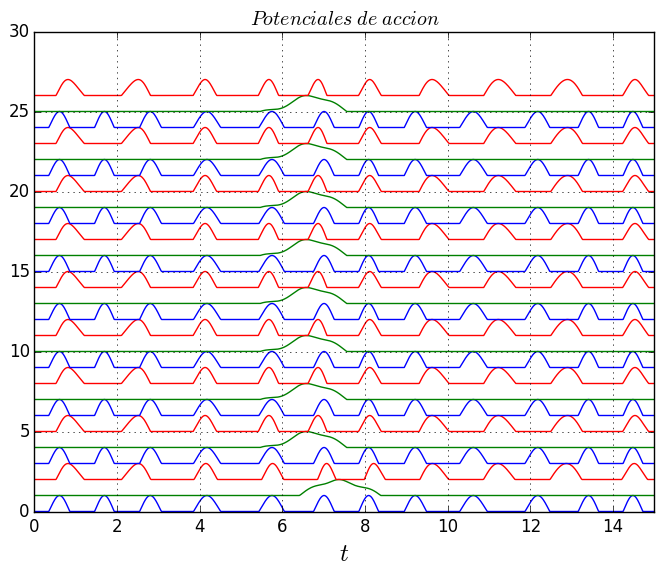

In [48]:
initial_cond=zeros(28)
[initial_cond[i]=-π for i in 2:28]
graficar(initial_cond,10,binaural,15.0,1e-15)